![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Proyecto 1 - Predicción de precios de vehículos usados

En este proyecto podrán poner en práctica sus conocimientos sobre modelos predictivos basados en árboles y ensambles, y sobre la disponibilización de modelos. Para su desasrrollo tengan en cuenta las instrucciones dadas en la "Guía del proyecto 1: Predicción de precios de vehículos usados".

**Entrega**: La entrega del proyecto deberán realizarla durante la semana 4. Sin embargo, es importante que avancen en la semana 3 en el modelado del problema y en parte del informe, tal y como se les indicó en la guía.

Para hacer la entrega, deberán adjuntar el informe autocontenido en PDF a la actividad de entrega del proyecto que encontrarán en la semana 4, y subir el archivo de predicciones a la [competencia de Kaggle](https://www.kaggle.com/t/4bd64c1deb3c4ffb8ca7ff93c1f1497d).

**Integrantes:**

 

* Alvaro José Pabón Fernández 

* Carlos Alonso Cañas Diaz  

* Luis Ignacio Bastidas Gutiérrez 

## Datos para la predicción de precios de vehículos usados

En este proyecto se usará el conjunto de datos de Car Listings de Kaggle, donde cada observación representa el precio de un automóvil teniendo en cuenta distintas variables como: año, marca, modelo, entre otras. El objetivo es predecir el precio del automóvil. Para más detalles puede visitar el siguiente enlace: [datos](https://www.kaggle.com/jpayne/852k-used-car-listings).

## Ejemplo predicción conjunto de test para envío a Kaggle

En esta sección encontrarán el formato en el que deben guardar los resultados de la predicción para que puedan subirlos a la competencia en Kaggle.

In [5]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
# Importación librerías
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PowerTransformer, FunctionTransformer
from sklearn.model_selection import GridSearchCV
import joblib

In [7]:
# Carga de datos de archivo .csv
dataTraining = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/dataTrain_carListings.zip')
dataTesting = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/dataTest_carListings.zip', index_col=0)

In [4]:
# Visualización datos de entrenamiento
dataTraining.head()

,Price,Year,Mileage,State,Make,Model
0,34995,2017,9913,FL,Jeep,Wrangler
1,37895,2015,20578,OH,Chevrolet,Tahoe4WD
2,18430,2012,83716,TX,BMW,X5AWD
3,24681,2014,28729,OH,Cadillac,SRXLuxury
4,26998,2013,64032,CO,Jeep,Wrangler


In [5]:
dataTraining.describe()

,Price,Year,Mileage
count,400000.000000,400000.000000,4.000000e+05
mean,21146.919312,2013.198125,5.507296e+04
std,10753.664940,3.292326,4.088102e+04
min,5001.000000,1997.000000,5.000000e+00
25%,13499.000000,2012.000000,2.584100e+04
50%,18450.000000,2014.000000,4.295500e+04
75%,26999.000000,2016.000000,7.743300e+04
max,79999.000000,2018.000000,2.457832e+06


## Preprocesamiento

 * Conversión de categorías a números: Utilizamos pd.factorize para realizar preprocesamiento, con este obtenemos un número por cada categoría. En este caso se aplica a las columnas ‘State’, ‘Make’, ‘Model’. Unimos los datos tanto de training como de testing para que las categorías quedaran igualmente representadas por el mismo número para ambos sets de datos como se muestra a continuación: 

In [8]:
# Aplicamos factorize tanto en training como en testing a la vez para conservar 
# el mismo número por clase en ambos datos

dataTraining_0 = dataTraining.copy()
dataTesting_0 = dataTesting.copy()

dataTraining_0['clase'] = 'train'
dataTesting_0[['clase']] = 'test'

total = pd.concat([dataTraining_0, dataTesting_0])

total['Model'] = pd.factorize(total.Model)[0]
total['State'] = pd.factorize(total.State)[0]
total['Make'] = pd.factorize(total.Make)[0]

dataTraining1 = total[total['clase'] == 'train'].drop(columns = ['clase'])
dataTesting1 = total[total['clase'] == 'test'].drop(columns = ['clase'])

dataTraining1.head()

,Price,Year,Mileage,State,Make,Model
0,34995.0,2017,9913,0,0,0
1,37895.0,2015,20578,1,1,1
2,18430.0,2012,83716,2,2,2
3,24681.0,2014,28729,1,3,3
4,26998.0,2013,64032,3,0,0


In [9]:
# X_train, y_train, X_test
X_train1 = dataTraining1.drop(['Price'], axis=1)
y_train = dataTraining1['Price']
X_test1 = dataTesting1.drop(['Price'], axis=1)

Revisamos el dataframe resultante del preprocesamiento anteriormente descrito :

In [8]:
X_train1.head(6)

,Year,Mileage,State,Make,Model
0,2014,31909,25,14,55
1,2017,5362,0,0,0
2,2014,50300,1,10,85
3,2004,132160,5,2,74
4,2015,25226,31,0,48
5,2017,25684,15,1,17


* Creamos un dataframe diferente, calculando el logaritmo sobre 'Mileage', agrupamiento de variables categóricas que tiene poca frecuencia en la columna 'Model' y finalmente Factorize como el procedimiento anterior:

<AxesSubplot:>

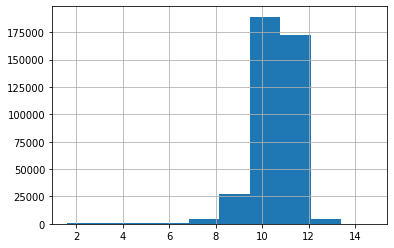

In [37]:
np.log(dataTraining['Mileage']).hist()

In [10]:
# X_train, y_train, X_test
X_train2 = dataTraining.drop(['Price'], axis=1)
y_train = dataTraining['Price']
X_test2 = dataTesting.copy()
X_test2.head()

,Year,Mileage,State,Make,Model
ID,,,,,
0,2014,31909,MD,Nissan,MuranoAWD
1,2017,5362,FL,Jeep,Wrangler
2,2014,50300,OH,Ford,FlexLimited
3,2004,132160,WA,BMW,5
4,2015,25226,MA,Jeep,Grand


In [11]:
# Transformación log sobre 'Mileage'

transformer = FunctionTransformer(np.log)

X_train2['Mileage'] = transformer.fit_transform(X_train2[['Mileage']])
X_test2['Mileage'] = transformer.transform(X_test2[['Mileage']])

X_train2.head()

,Year,Mileage,State,Make,Model
0,2017,9.201602,FL,Jeep,Wrangler
1,2015,9.931978,OH,Chevrolet,Tahoe4WD
2,2012,11.335185,TX,BMW,X5AWD
3,2014,10.265662,OH,Cadillac,SRXLuxury
4,2013,11.067138,CO,Jeep,Wrangler


In [12]:
# Revisión de categorias con poca frecuencia
df = dataTraining['Model'].value_counts().to_frame()
df['porc'] = df['Model'] / df['Model'].sum()
df['cumsum'] = df['porc'].cumsum()
df.tail(10)

,Model,porc,cumsum
MustangDeluxe,57,0.000142,0.998807
Continental,57,0.000142,0.998950
ImprezaSport,56,0.000140,0.999090
Yaris4dr,56,0.000140,0.999230
RegalGS,54,0.000135,0.999365
PathfinderSE,53,0.000132,0.999497
Galant4dr,53,0.000132,0.999630
SLK-ClassSLK350,52,0.000130,0.999760
Monte,48,0.000120,0.999880
RX-84dr,48,0.000120,1.000000


Convertir los de poca frequencia en 'Others' tanto en traingin como en testing:

In [13]:
lista = df[df['porc'] <= 0.0002].index

X_train2['Model'] = np.where(dataTraining["Model"].isin(lista), "Others", dataTraining["Model"])
X_test2['Model'] = np.where(dataTesting["Model"].isin(lista), "Others", dataTesting["Model"])

X_train2[X_train2['Model'] == 'Others'].head()

,Year,Mileage,State,Make,Model
278,2008,11.632653,FL,Toyota,Others
328,2017,9.861206,SC,Volvo,Others
351,2008,11.944390,IN,Hyundai,Others
491,2004,11.954735,NE,GMC,Others
607,2007,11.987854,WA,Toyota,Others


Aplicamos factorize tanto en training como en testing a la vez para conservar el mismo número por clase en ambos datos:

In [14]:
X_train2['clase'] = 'train'
X_test2['clase'] = 'test'

total2 = pd.concat([X_train2, X_test2])

total2['Model'] = pd.factorize(total2.Model)[0]
total2['State'] = pd.factorize(total2.State)[0]
total2['Make'] = pd.factorize(total2.Make)[0]

X_train2 = total2[total2['clase'] == 'train'].drop(columns = ['clase'])
X_test2 = total2[total2['clase'] == 'test'].drop(columns = ['clase'])

X_train2.head()

,Year,Mileage,State,Make,Model
0,2017,9.201602,0,0,0
1,2015,9.931978,1,1,1
2,2012,11.335185,2,2,2
3,2014,10.265662,1,3,3
4,2013,11.067138,3,0,0


In [15]:
X_test2.head()

,Year,Mileage,State,Make,Model
0,2014,10.370643,25,14,55
1,2017,8.587092,0,0,0
2,2014,10.825760,1,10,85
3,2004,11.791769,5,2,74
4,2015,10.135630,31,0,48


## Calibración

### XGBoost con calibración

El modelo escogido para realizar el taller es un XGBoost, los parámetros escogidos para calibración fueron los siguiente: 

 

* **max_depth:** La profundidad máxima permitida para los árboles. 

* **learning_rate:** Tasa de aprendizaje para el algoritmo de gradient boosting. 

* **n_estimators:** Número de árboles. 

* **colsample_bytree:** Índice de subconjunto de las columnas utilizadas para cada árbol. 

 

Para realizar la calibración de los cuatro parámetros descritos anteriormente utilizamos el método GridSearchCV de sklearn, el cual intenta todas las combinaciones de los valores dados a los parámetros y evalúa el modelo para cada combinación usando el método de cross-validation y como indicador ‘neg_mean_squared_error’.


 

Realizamos GridSearchCV con el dataframe 1: 

In [ ]:
params = { 'max_depth': [10, 12],
           'learning_rate': [0.01, 0.05, 0.1],
           'n_estimators': [300, 500],
           'colsample_bytree': [0.8, 0.9]}

xgbr = XGBRegressor(seed = 20)

clf = GridSearchCV(estimator=xgbr, 
                   param_grid=params,
                   scoring='neg_mean_squared_error', 
                   verbose=1)
clf.fit(X_train1, y_train)
print("Mejores parámetros:", clf.best_params_)
print("Minímo RMSE: ", (-clf.best_score_)**(1/2.0))

Calibración del modelo con el data frame 2:

In [24]:
params = { 'max_depth': [10, 12],
           'learning_rate': [0.01, 0.05, 0.1],
           'n_estimators': [300, 500],
           'colsample_bytree': [0.8, 0.9]}

xgbr = XGBRegressor(seed = 20)

clf = GridSearchCV(estimator=xgbr, 
                   param_grid=params,
                   scoring='neg_mean_squared_error', 
                   verbose=1)
clf.fit(X_train2, y_train)
print("Mejores parámetros:", clf.best_params_)
print("Minímo RMSE: ", (-clf.best_score_)**(1/2.0))

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Mejores parámetros: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 500}
Minímo RMSE:  3515.1861843445636


Los parámetros max_depth, learning_rate, n_estimators, colsample_bytree son unos de los más comunes que se calibran con el objetivo de afectar de manera positiva la predicción del modelo. max_depth probamos números 10 y 12, learning_rate 0.01, 0.05 y 0.1, n_estimators 300 y 500 y colsample_bytree 0.8 y 0.9.

## Entrenamiento del modelo

**Inicialmente entrenamos un modelo XGBoost sin calibración para tener un modelo base:**


In [16]:
xgb_model0 = XGBRegressor()
xgb_model0.fit(X_train1, y_train)
y_pred0 = xgb_model0.predict(X_test1)
y_pred0

array([20072.75 , 37506.387, 24994.844, ..., 22014.531, 17080.838,
       24461.023], dtype=float32)

In [17]:
# Guardar predicciones en formato exigido en la competencia de kaggle
y_pred0=pd.DataFrame(y_pred0, columns=['Price'])
y_pred0.index.rename('ID', inplace=True)
y_pred0.to_csv('test_submission0.csv')

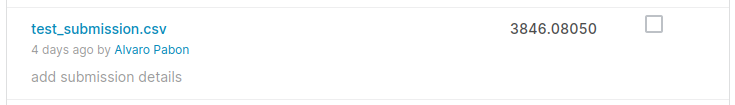

El puntaje (Scoring) obtenido en la competencia de **kaggle : 3846.08050**

#### Entrenando modelo con el primer dataframe con los mejores parametros encontrados:

In [28]:
xgb_model1 = XGBRegressor(colsample_bytree = 0.8, learning_rate = 0.1, max_depth = 10, n_estimators = 500)
xgb_model1.fit(X_train1, y_train)
y_pred1 = xgb_model1.predict(X_test1)

y_pred1

array([21004.512, 37018.906, 23191.494, ..., 22866.584, 17476.941,
       22033.162], dtype=float32)

In [29]:
# Guardar predicciones en formato exigido en la competencia de kaggle
y_pred1=pd.DataFrame(y_pred1, columns=['Price'])
y_pred1.index.rename('ID', inplace=True)
y_pred1.to_csv('test_submission1.csv')
#3447.16221

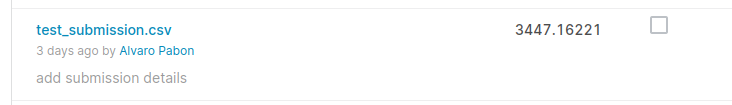

Escogimos XGBoostRegressor por ser un modelo robusto algoritmicamente y usando el dataframe preprocesado unicamente con factorize y al calibrar los parámetros max_depth, learning_rate, n_estimators, colsample_bytree nos arrojo el mejor desempeno en Kaggle.

In [34]:
#Exportar modelo
joblib.dump(xgb_model1, 'precio_model.pkl', compress=3)

['precio_model.pkl']

#### Entrenando modelo con el segundo dataframe con los mejores parámestros encontrados:

In [25]:
xgb_model2 = XGBRegressor(colsample_bytree = 0.8, learning_rate = 0.1, max_depth = 10, n_estimators = 500)
xgb_model2.fit(X_train2, y_train)
y_pred2 = xgb_model2.predict(X_test2)

y_pred2
# 3484.49

array([21333.766, 36386.73 , 23208.727, ..., 22563.596, 17330.15 ,
       20566.973], dtype=float32)

In [26]:
y_pred2=pd.DataFrame(y_pred2, columns=['Price'])
y_pred2.index.rename('ID', inplace=True)
y_pred2.to_csv('test_submission2.csv')

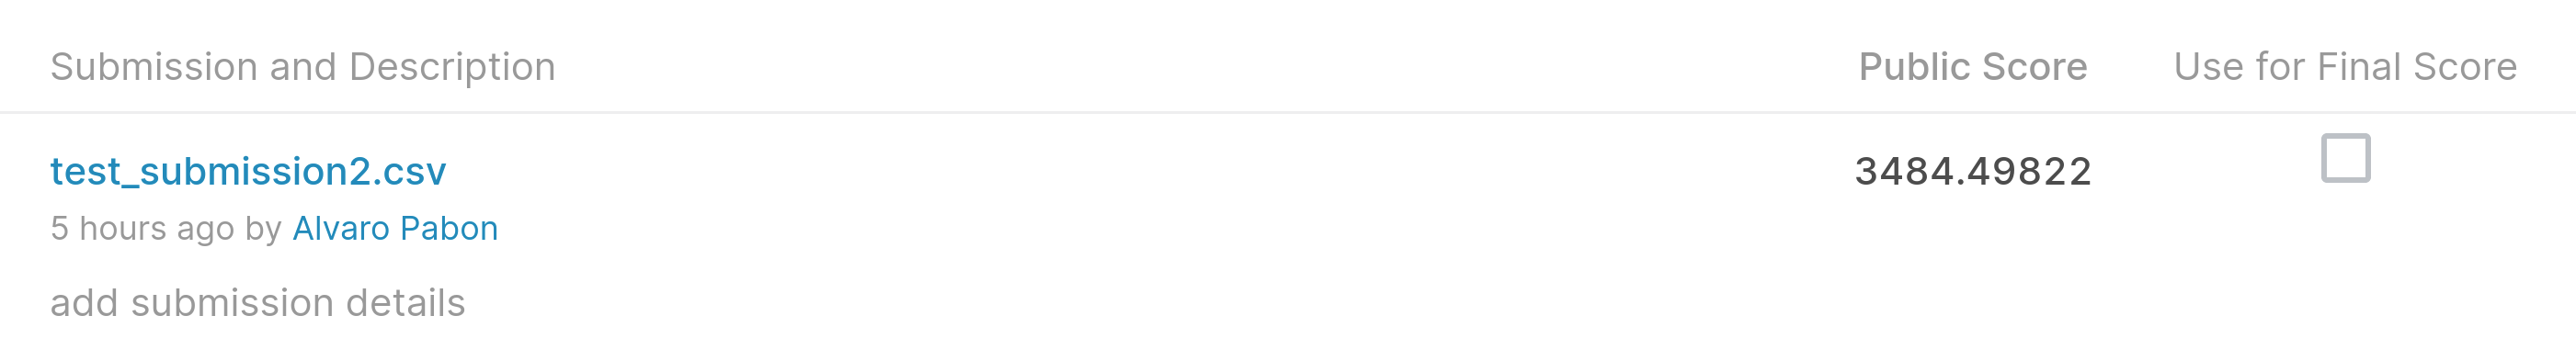

## Disponibilización del modelo

## Conclusión

Para este taller, probamos con un modelo XGBoost. Se realizaron pre-procesamientos sobre la base de datos original entre las cuales estan conversión de variables categoricas a númericas, se calculo el logaritmo sobre una variable y se agruparon categorias con poca frecuencia.

Se realizo un modelo base XGBoost sin calibración con el dataframe 1(preprocesamiento con factorize) el cual arrojo un score en kaggle de 3846.08, paso siguiente se realizo una calibración del modelo sobre el mismo dataframe1 probando diferentes valores para los parámetros max_depth, learning_rate, n_estimators y colsample_bytree, por el cual obtuvimos un score de 3447.16 y finalmente entrenamos un modelo sobre el dataframe con los preprocesamientos extras (log, agrupamiento) arrojando un score de 3484.49.

Seleccionamos el modelo 2 con un score de 3447.16 por tener el mejor score en la competencia de kaggle y procedimos a crear un api sobre aws para disponibilizar el modelo.